In [2]:
import os

def total_files(folder_path):
    if not os.path.exists(folder_path):
        return 0
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

train_files_healthy = "Dataset/Train/Train/Healthy"
train_files_powdery = "Dataset/Train/Train/Powdery"
train_files_rust = "Dataset/Train/Train/Rust"

test_files_healthy = "Dataset/Test/Test/Healthy"
test_files_powdery = "Dataset/Test/Test/Powdery"
test_files_rust = "Dataset/Test/Test/Rust"

valid_files_healthy = "Dataset/Validation/Validation/Healthy"
valid_files_powdery = "Dataset/Validation/Validation/Powdery"
valid_files_rust = "Dataset/Validation/Validation/Rust"

print("Training set:")
print("Healthy:", total_files(train_files_healthy))
print("Powdery:", total_files(train_files_powdery))
print("Rust:", total_files(train_files_rust))

print("\nTest set:")
print("Healthy:", total_files(test_files_healthy))
print("Powdery:", total_files(test_files_powdery))
print("Rust:", total_files(test_files_rust))

print("\nValidation set:")
print("Healthy:", total_files(valid_files_healthy))
print("Powdery:", total_files(valid_files_powdery))
print("Rust:", total_files(valid_files_rust))


Training set:
Healthy: 458
Powdery: 430
Rust: 434

Test set:
Healthy: 50
Powdery: 50
Rust: 50

Validation set:
Healthy: 20
Powdery: 20
Rust: 20


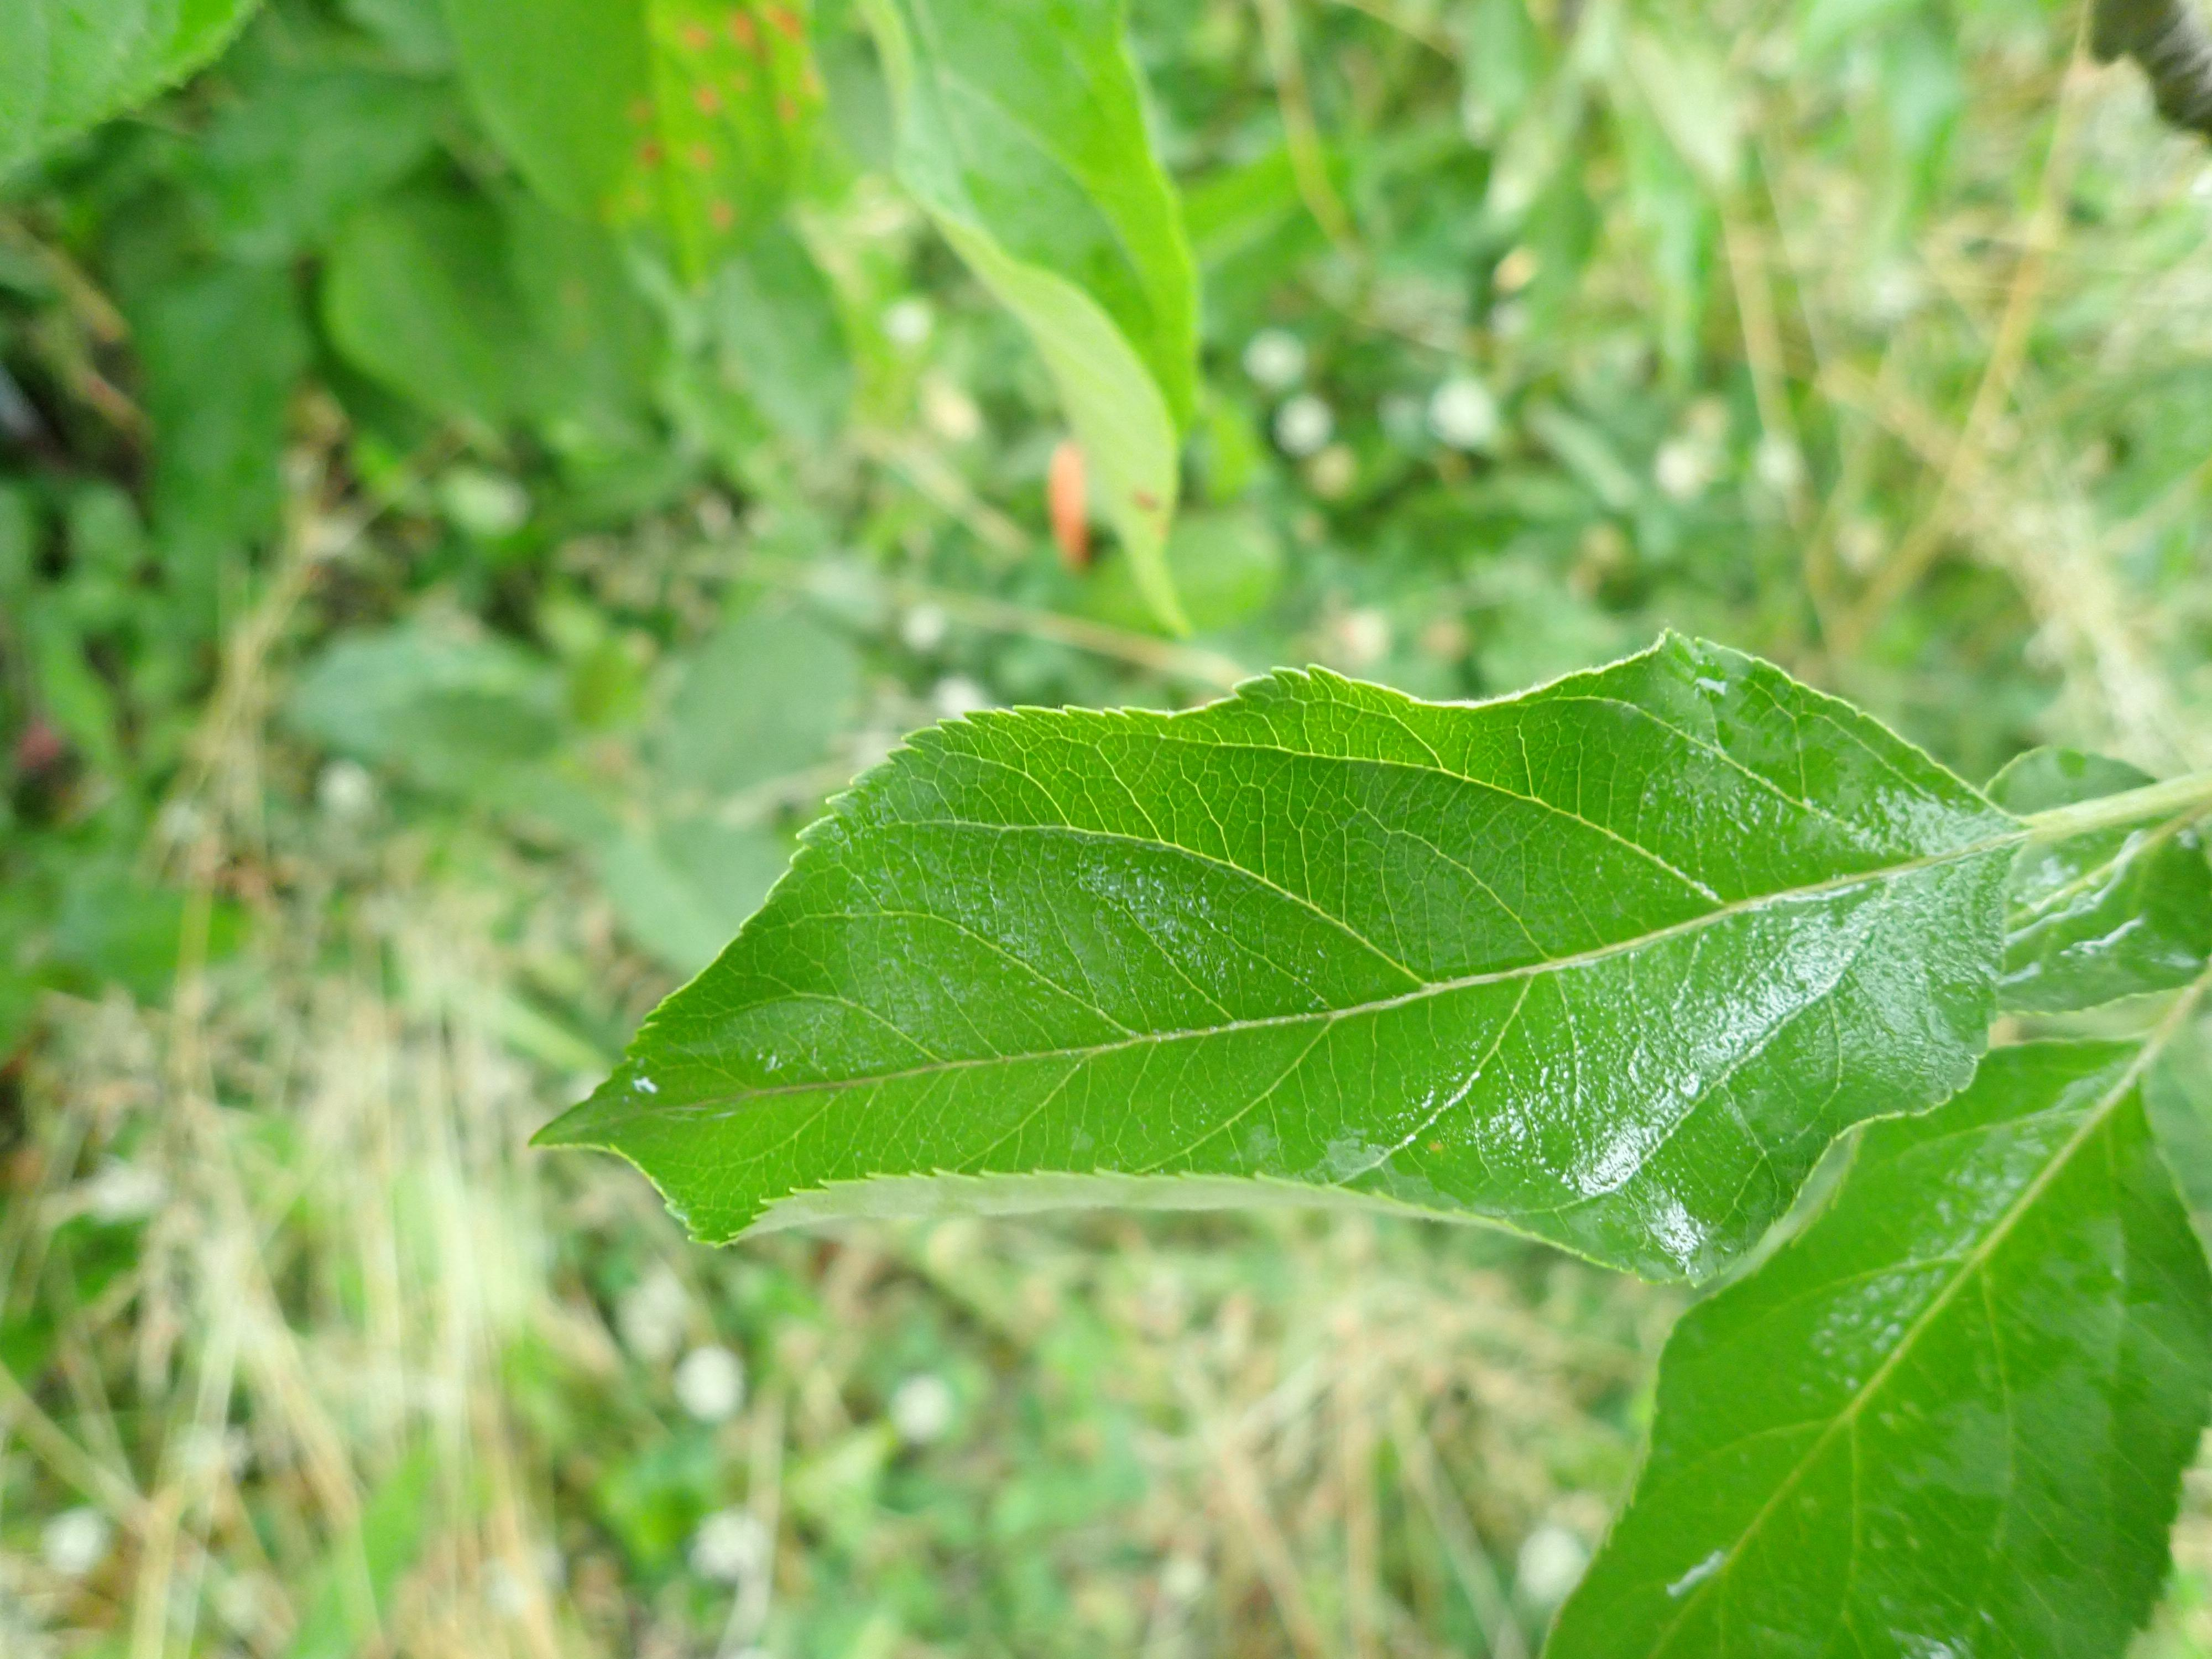

In [3]:
from PIL import Image
import IPython.display as display
import os

sample_dir = "Dataset/Train/Train/Healthy"
files = os.listdir(sample_dir)
img_path = os.path.join(sample_dir, files[0])

with open(img_path, "rb") as f:
    display.display(display.Image(data=f.read(), width=400))


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (225, 225)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "Dataset/Train/Train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    "Dataset/Validation/Validation",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    "Dataset/Test/Test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

train_generator.class_indices


Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(225,225,3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 223, 223, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stop]
)

model.save("final_model.h5")


Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3701 - loss: 1.4436

42/42 ━━━━━━━━━━━━━━━━━━━━ 288s 7s/step - accuracy: 0.3873 - loss: 1.1729 - val_accuracy: 0.5333 - val_loss: 0.8436
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5664 - loss: 0.8350

42/42 ━━━━━━━━━━━━━━━━━━━━ 217s 5s/step - accuracy: 0.6036 - loss: 0.7820 - val_accuracy: 0.8000 - val_loss: 0.4491
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8296 - loss: 0.4487

42/42 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.8396 - loss: 0.4275 - val_accuracy: 0.8500 - val_loss: 0.3574
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9254 - loss: 0.2390

42/42 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.9070 - loss: 0.2733 - val_accuracy: 0.8833 - val_loss: 0.3656
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - accuracy: 0.9244 - loss: 0.2264 - val_accuracy: 0.8333 - val_loss: 0.3491
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9249 - loss: 0.2264

42/42 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.9342 - loss: 0.1957 - val_accuracy: 0.9333 - val_loss: 0.2691
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.9304 - loss: 0.2330 - val_accuracy: 0.8500 - val_loss: 0.3892
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 192s 5s/step - accuracy: 0.9115 - loss: 0.2657 - val_accuracy: 0.8667 - val_loss: 0.3391
Epoch 9/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - accuracy: 0.9380 - loss: 0.1800 - val_accuracy: 0.8833 - val_loss: 0.4328
Epoch 10/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 297s 7s/step - accuracy: 0.9433 - loss: 0.1620 - val_accuracy: 0.9000 - val_loss: 0.4291
Epoch 11/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.9569 - loss: 0.1246 - val_accuracy: 0.8500 - val_loss: 0.4439


In [12]:
import os
print("best:", os.path.exists("best_model.h5"))
print("final:", os.path.exists("final_model.h5"))


best: True
final: True


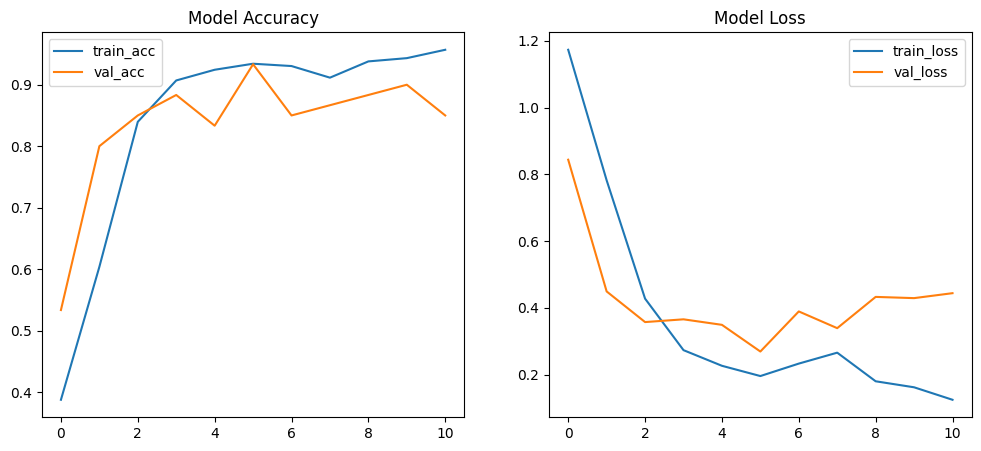

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Model Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Model Loss")
plt.legend()

plt.show()


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import os

def preprocess_image(path):
    img = load_img(path, target_size=(225,225))
    x = img_to_array(img) / 255.0
    return np.expand_dims(x, axis=0)

model = load_model("best_model.h5")

# get labels mapping
labels = train_generator.class_indices
labels = {v:k for k,v in labels.items()}
print("Label Map:", labels)

# test on one rust image
test_dir = "Dataset/Test/Test/Rust"
filename = os.listdir(test_dir)[0]
path = os.path.join(test_dir, filename)

x = preprocess_image(path)
pred = model.predict(x)
cls = np.argmax(pred)

print("Predicted:", labels[cls])


Label Map: {0: 'Healthy', 1: 'Powdery', 2: 'Rust'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
Predicted: Rust


In [23]:
# Improved make_gradcam_heatmap (robust + Gaussian blur)
from PIL import Image, ImageFilter
import numpy as np
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, blur_radius=2):
    """
    Robust Grad-CAM:
      - builds a small functional grad_model (replaying layers)
      - computes gradients, falls back to abs-grad if necessary
      - smooths heatmap with PIL GaussianBlur
    Returns: heatmap (H,W) float32 0..1
    """
    # Build small functional grad_model (same approach we used earlier)
    from tensorflow.keras import Input, Model
    inp = Input(shape=(img_array.shape[1], img_array.shape[2], img_array.shape[3]))
    x = inp
    last_conv_output = None
    for layer in model.layers:
        if layer.__class__.__name__ == "InputLayer":
            continue
        x = layer(x)
        if layer.name == last_conv_layer_name:
            last_conv_output = x
            break
    if last_conv_output is None:
        raise ValueError(f"Last conv layer {last_conv_layer_name} not found when building grad model.")

    y = last_conv_output
    after = False
    for layer in model.layers:
        if after:
            y = layer(y)
        if layer.name == last_conv_layer_name:
            after = True

    grad_model = Model(inputs=inp, outputs=[last_conv_output, y])

    # Ensure built
    try:
        _ = grad_model(np.zeros(img_array.shape, dtype=np.float32))
    except Exception:
        pass

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    # If grads are None or extremely tiny, try absolute-gradients fallback
    if grads is None:
        raise RuntimeError("Gradients returned None — cannot compute Grad-CAM.")
    grads_np = np.array(grads)
    max_abs_grad = float(np.max(np.abs(grads_np)))
    if max_abs_grad < 1e-8:
        # fallback: use absolute activations *or pooled absolute grads
        pooled_grads = np.mean(np.abs(grads_np), axis=(0,1,2))
    else:
        pooled_grads = np.array(tf.reduce_mean(grads, axis=(0,1,2)).numpy())

    conv_outputs_np = np.array(conv_outputs[0].numpy())  # shape (h,w,filters)

    # weighted sum of feature maps
    weights = pooled_grads.reshape((1,1,-1))
    weighted_maps = conv_outputs_np * weights
    heatmap = np.sum(weighted_maps, axis=-1)

    # ReLU + normalize
    heatmap = np.maximum(heatmap, 0.0)
    minv, maxv = float(np.min(heatmap)), float(np.max(heatmap))
    if maxv - minv <= 1e-8:
        # if heatmap is constant (or zero), try a different strategy: use mean of absolute conv maps
        heatmap = np.mean(np.abs(conv_outputs_np), axis=-1)
        minv, maxv = float(np.min(heatmap)), float(np.max(heatmap))
        if maxv - minv <= 1e-8:
            # still flat — return zeros (will result in dim overlay)
            heatmap = np.zeros_like(heatmap, dtype=np.float32)
            # convert to 0..1
            return heatmap.astype(np.float32)

    # normalize to 0..1
    heatmap = (heatmap - minv) / (maxv - minv + 1e-12)
    # convert to image, resize to model input size, apply small blur to make hotspots visible
    heat_pil = Image.fromarray(np.uint8(heatmap * 255))
    heat_pil = heat_pil.resize((img_array.shape[2], img_array.shape[1]), resample=Image.BILINEAR)
    if blur_radius > 0:
        heat_pil = heat_pil.filter(ImageFilter.GaussianBlur(radius=blur_radius))
    heatmap = np.array(heat_pil).astype('float32') / 255.0
    return heatmap


Loaded model: sequential_2
Model built successfully.
Using last conv layer: conv2d_8
Label map: {0: 'Healthy', 1: 'Powdery', 2: 'Rust'}
Sample image: Dataset/Test/Test/Rust\82add70df6ab2854.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
Predicted: Rust (index 2) with confidence 1.0000
=== DEBUG INFO ===
pre.shape, dtype: (1, 225, 225, 3) float32
model layers: ['conv2d_6', 'max_pooling2d_6', 'conv2d_7', 'max_pooling2d_7', 'conv2d_8', 'max_pooling2d_8', 'flatten_2', 'dense_4', 'dense_5']
last_conv: conv2d_8
Built grad_model outputs shapes: [(None, 52, 52, 128), (None, 3)]
conv_outs.shape: (1, 52, 52, 128)
preds.shape: (1, 3)
grads type: <class 'NoneType'> shape: None
=== END DEBUG ===


C:\Users\DELL\AppData\Local\Temp\ipykernel_12608\2065666909.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap(cmap)


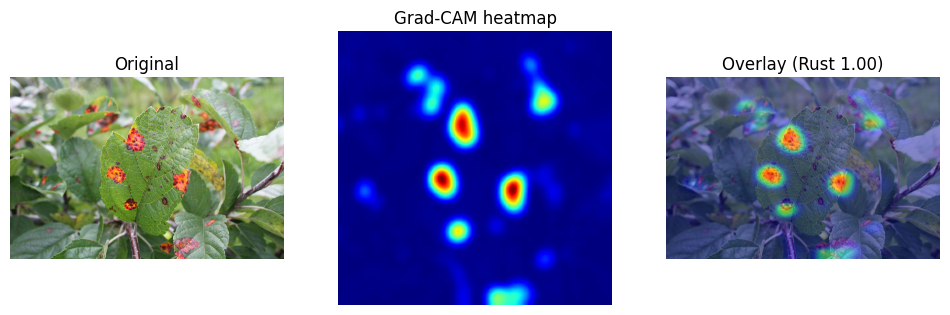

Saved overlay to gradcam_overlay.jpg


In [24]:
# Load model (best saved model) and produce Grad-CAM for one test image
model_path = "best_model.h5"   # change if your model file name differs
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")
model = load_model(model_path)
print("Loaded model:", model.name)

# FIX: Build the model by calling it once
model(np.zeros((1, 225, 225, 3)))
print("Model built successfully.")


# determine last conv layer (auto)
last_conv = find_last_conv_layer(model)
if last_conv is None:
    # as we saw in your model summary last conv layer was likely 'conv2d_5'
    last_conv = "conv2d_5"
print("Using last conv layer:", last_conv)

# label mapping (from your generator)
label_map = {v: k for k, v in train_generator.class_indices.items()}
print("Label map:", label_map)

# pick a sample test image (change path if you want)
sample_test_dir = "Dataset/Test/Test/Rust"
test_files = [f for f in os.listdir(sample_test_dir) if os.path.isfile(os.path.join(sample_test_dir, f))]
if len(test_files) == 0:
    raise RuntimeError("No test images found in " + sample_test_dir)
sample_img_path = os.path.join(sample_test_dir, test_files[0])
print("Sample image:", sample_img_path)

# load original image as PIL
orig = Image.open(sample_img_path).convert("RGB")
# preprocess for model
pre = preprocess_pil(orig, target_size=(225,225))

# predict
preds = model.predict(pre)
pred_idx = int(np.argmax(preds[0]))
conf = float(np.max(preds[0]))
pred_label = label_map[pred_idx]
print(f"Predicted: {pred_label} (index {pred_idx}) with confidence {conf:.4f}")


# DEBUG block — run right before calling make_gradcam_heatmap(pre, model, last_conv, pred_idx)
import numpy as np, tensorflow as tf, traceback

print("=== DEBUG INFO ===")
print("pre.shape, dtype:", getattr(pre, "shape", None), getattr(pre, "dtype", None))
print("model layers:", [l.name for l in model.layers])
print("last_conv:", last_conv)

# Build grad_model like we do inside function to inspect shapes
from tensorflow.keras import Input, Model
inp = Input(shape=(225,225,3))
x = inp
last_conv_output = None
for layer in model.layers:
    if layer.__class__.__name__ == "InputLayer":
        continue
    x = layer(x)
    if layer.name == last_conv:
        last_conv_output = x
        break

if last_conv_output is None:
    print("ERROR: last_conv not found while replaying layers. Layer name may be wrong.")
else:
    y = last_conv_output
    after=False
    for layer in model.layers:
        if after:
            y = layer(y)
        if layer.name == last_conv:
            after=True
    grad_model = Model(inputs=inp, outputs=[last_conv_output, y])
    print("Built grad_model outputs shapes:", [o.shape for o in grad_model.outputs])
    # forward pass
    pre_arr = pre.astype(np.float32)
    conv_outs, preds = grad_model(pre_arr)
    print("conv_outs.shape:", conv_outs.shape)
    print("preds.shape:", preds.shape)
    # compute grads quickly to inspect
    try:
        with tf.GradientTape() as tape:
            tape.watch(conv_outs)
            class_channel = preds[:, np.argmax(preds[0])]
        grads = tape.gradient(class_channel, conv_outs)
        print("grads type:", type(grads), "shape:", None if grads is None else grads.shape)
        if grads is not None:
            print("grads min/max:", float(tf.reduce_min(grads).numpy()), float(tf.reduce_max(grads).numpy()))
            pooled = tf.reduce_mean(grads, axis=(0,1,2))
            print("pooled_grads min/max:", float(tf.reduce_min(pooled).numpy()), float(tf.reduce_max(pooled).numpy()))
    except Exception as e:
        print("Gradient computation failed:")
        traceback.print_exc()
print("=== END DEBUG ===")


# compute heatmap
heatmap = make_gradcam_heatmap(pre, model, last_conv, pred_idx)
# overlay
overlay = overlay_heatmap(orig, heatmap, alpha=0.45)

# display side-by-side
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.axis('off')
plt.imshow(orig)
plt.subplot(1,3,2)
plt.title("Grad-CAM heatmap")
plt.axis('off')
plt.imshow(heatmap, cmap='jet')
plt.subplot(1,3,3)
plt.title(f"Overlay ({pred_label} {conf:.2f})")
plt.axis('off')
plt.imshow(overlay)
plt.show()

# save overlay image
overlay_save_path = "gradcam_overlay.jpg"
overlay.save(overlay_save_path)
print("Saved overlay to", overlay_save_path)
